In [5]:
from typing import List, Tuple, Dict, Optional
import torch
import numpy as np
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification
import torch.nn.functional as F
import matplotlib.pyplot as plt
from dataclasses import dataclass
from tqdm import tqdm
import random
import logging
import os
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

def clean_token(token: str) -> str:
    """Clean special tokens from GPT-2 tokenizer output."""
    # Remove 'Ġ' character that represents spaces
    return token.replace('Ġ', '')

@dataclass
class Sample:
    """Class for keeping track of a sample with its metadata."""
    text: str
    label: str
    score: Optional[float] = None
    explanation: Optional[List[str]] = None

class ProxyModel:
    """GPT-2 based proxy model as used in the paper."""
    def __init__(self, num_labels: int, device: str = "cuda" if torch.cuda.is_available() else "cpu"):
        logger.info(f"Initializing ProxyModel with {num_labels} labels on {device}")
        self.device = device
        self.num_labels = num_labels
        
        # Initialize tokenizer and model
        try:
            self.tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
            self.model = GPT2ForSequenceClassification.from_pretrained('gpt2', num_labels=num_labels)
            
            # Add padding token if not present
            if self.tokenizer.pad_token is None:
                self.tokenizer.pad_token = self.tokenizer.eos_token
                self.model.config.pad_token_id = self.tokenizer.eos_token_id
            
            self.model.to(device)
            self.model.eval()
            
        except Exception as e:
            logger.error(f"Error initializing model: {str(e)}")
            raise

    def predict(self, text: str) -> Dict[str, float]:
        """Generate prediction scores."""
        try:
            inputs = self.tokenizer(
                text,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=512
            ).to(self.device)
            
            with torch.no_grad():
                outputs = self.model(**inputs)
            
            probs = F.softmax(outputs.logits, dim=-1)[0].cpu()
            return {str(i): float(prob) for i, prob in enumerate(probs)}
            
        except Exception as e:
            logger.error(f"Error in prediction: {str(e)}")
            return {str(i): 0.0 for i in range(self.num_labels)}

class ExplanationGenerator:
    def __init__(self, proxy_model: ProxyModel):
        self.proxy_model = proxy_model

    def vanilla_gradients(self, text: str, label: str) -> np.ndarray:
        """Generate explanations using vanilla gradients."""
        try:
            self.proxy_model.model.zero_grad()
            
            inputs = self.proxy_model.tokenizer(
                text,
                return_tensors="pt",
                padding=True,
                truncation=True
            ).to(self.proxy_model.device)
            
            embeddings = self.proxy_model.model.transformer.wte(inputs["input_ids"])
            embeddings.retain_grad()
            
            outputs = self.proxy_model.model(inputs_embeds=embeddings)
            target_class = int(label)
            
            # Just use gradients without multiplying by input
            outputs.logits[0, target_class].backward()
            
            gradients = embeddings.grad
            if gradients is None:
                return np.zeros(len(inputs["input_ids"][0]))
            
            # Take L2 norm of gradients
            token_attributions = torch.norm(gradients[0], p=2, dim=-1).cpu().numpy()
            tokens = [clean_token(token) for token in self.proxy_model.tokenizer.tokenize(text)]
            token_attributions = [attr for attr, token in zip(token_attributions, tokens) if token and token.lower() not in stopwords.words('english')]
            
            return np.array(token_attributions)
            
            return token_attributions
            
        except Exception as e:
            logger.error(f"Error in vanilla gradients: {str(e)}")
            return np.zeros(1)

    def contrastive_gradients(self, text: str, label: str) -> np.ndarray:
        """Generate contrastive explanations."""
        try:
            self.proxy_model.model.zero_grad()
            
            inputs = self.proxy_model.tokenizer(
                text,
                return_tensors="pt",
                padding=True,
                truncation=True
            ).to(self.proxy_model.device)
            
            # Get predictions first
            with torch.no_grad():
                outputs = self.proxy_model.model(**inputs)
                predicted_class = outputs.logits.argmax(dim=-1).item()
            
            # Get gradients for true class
            embeddings = self.proxy_model.model.transformer.wte(inputs["input_ids"])
            embeddings.retain_grad()
            
            outputs = self.proxy_model.model(inputs_embeds=embeddings)
            target_class = int(label)
            
            # First backward pass with retain_graph=True
            outputs.logits[0, target_class].backward(retain_graph=True)
            true_gradients = embeddings.grad.clone()
            
            # Reset gradients
            self.proxy_model.model.zero_grad()
            embeddings.grad = None
            
            # Second backward pass for predicted class
            outputs = self.proxy_model.model(inputs_embeds=embeddings)
            outputs.logits[0, predicted_class].backward()
            pred_gradients = embeddings.grad.clone()
            
            if true_gradients is None or pred_gradients is None:
                return np.zeros(len(inputs["input_ids"][0]))
            
            # Compute contrastive gradients
            contrastive = true_gradients - pred_gradients
            tokens = [clean_token(token) for token in self.proxy_model.tokenizer.tokenize(text)]
            true_gradients = [attr for attr, token in zip(true_gradients[0], tokens) if token and token.lower() not in stopwords.words('english')]
            pred_gradients = [attr for attr, token in zip(pred_gradients[0], tokens) if token and token.lower() not in stopwords.words('english')]
            
            contrastive = np.array(true_gradients) - np.array(pred_gradients)
            return np.linalg.norm(contrastive, ord=2, axis=-1)
            
        except Exception as e:
            logger.error(f"Error in contrastive gradients: {str(e)}")
            return np.zeros(1)

    def generate_explanation(self, text: str, label: str, method: str = "vanilla") -> np.ndarray:
        """Generate explanations using specified method."""
        if method == "vanilla":
            return self.vanilla_gradients(text, label)
        elif method == "contrastive":
            return self.contrastive_gradients(text, label)
        else:
            logger.warning(f"Unknown method {method}, falling back to vanilla gradients")
            return self.vanilla_gradients(text, label)

class SampleSelector:
    """Selects samples based on Misclassification Confidence Score."""
    def __init__(self, proxy_model: ProxyModel, top_k: int):
        self.proxy_model = proxy_model
        self.top_k = top_k

    def compute_mcs(self, text: str, true_label: str) -> float:
        """Compute Misclassification Confidence Score."""
        try:
            predictions = self.proxy_model.predict(text)
            true_score = predictions.get(true_label, 0)
            max_false_score = max(
                (score for label, score in predictions.items() if label != true_label),
                default=0
            )
            return max_false_score - true_score
        except Exception as e:
            logger.error(f"Error computing MCS: {str(e)}")
            return 0.0

    def select_samples(self, samples: List[Tuple[str, str]]) -> List[Sample]:
        """Select top-k samples based on MCS."""
        scored_samples = []
        
        for text, label in tqdm(samples, desc="Computing MCS scores"):
            try:
                mcs = self.compute_mcs(text, label)
                scored_samples.append(Sample(text=text, label=label, score=mcs))
            except Exception as e:
                logger.error(f"Error processing sample: {str(e)}")
                continue
        
        scored_samples.sort(key=lambda x: x.score if x.score is not None else float('-inf'), reverse=True)
        return scored_samples[:self.top_k]

class AMPLIFY:
    """Main AMPLIFY framework implementation."""
    def __init__(
        self,
        num_labels: int,
        top_k_samples: int = 3,
        top_k_keywords: int = 5,
        device: str = "cuda" if torch.cuda.is_available() else "cpu"
    ):
        logger.info("Initializing AMPLIFY framework")
        self.num_labels = num_labels
        self.device = device
        self.top_k_samples = top_k_samples
        self.top_k_keywords = top_k_keywords
        
        # Initialize components
        self.proxy_model = ProxyModel(num_labels=num_labels, device=device)
        self.explanation_generator = ExplanationGenerator(self.proxy_model)
        self.sample_selector = SampleSelector(self.proxy_model, top_k_samples)

    def visualize_scores(self, samples: List[Sample], save_path: Optional[str] = None):
        """Visualize MCS distribution."""
        scores = [s.score for s in samples if s.score is not None]
        if not scores:
            logger.warning("No scores to visualize")
            return

        plt.figure(figsize=(10, 6))
        plt.hist(scores, bins=20, color='blue', alpha=0.7)
        plt.title("Misclassification Confidence Score Distribution")
        plt.xlabel("MCS")
        plt.ylabel("Frequency")
        plt.grid(True)
        
        if save_path:
            plt.savefig(save_path)
            logger.info(f"Plot saved to {save_path}")
        else:
            plt.show()
        plt.close()

    def generate_prompt(self, samples: List[Sample]) -> str:
        """Generate the complete prompt with explanations."""
        prompt_parts = []
        
        for sample in tqdm(samples, desc="Generating explanations"):
            try:
                # Generate attributions
                attributions = self.explanation_generator.generate_explanation(
                    sample.text,
                    sample.label
                )
                
                # Get tokens and match lengths
                tokens = self.proxy_model.tokenizer.tokenize(sample.text)
                min_len = min(len(tokens), len(attributions))
                tokens = tokens[:min_len]
                attributions = attributions[:min_len]
                
                # Get top keywords and clean them
                token_scores = list(zip(tokens, attributions))
                token_scores.sort(key=lambda x: x[1], reverse=True)
                top_keywords = [clean_token(token) for token, _ in token_scores[:self.top_k_keywords]]
                
                # Store explanation
                sample.explanation = top_keywords
                
                # Format prompt
                rationale = (
                    f"The key words: {', '.join(top_keywords)} are crucial clues "
                    f"for predicting {sample.label} as the correct answer."
                )
                prompt_part = (
                    f"Input: {sample.text}\n"
                    f"Rationale: {rationale}\n"
                    f"Label: {sample.label}\n"
                )
                prompt_parts.append(prompt_part)
                
            except Exception as e:
                logger.error(f"Error generating prompt part: {str(e)}")
                continue
        
        return "\n".join(prompt_parts)

    def run(
        self,
        validation_set: List[Tuple[str, str]],
        visualize: bool = True,
        save_plot: Optional[str] = None
    ) -> str:
        """Execute the complete AMPLIFY pipeline."""
        try:
            logger.info("Starting AMPLIFY pipeline")
            
            # Step 1: Select samples
            logger.info("Selecting samples using MCS")
            selected_samples = self.sample_selector.select_samples(validation_set)
            
            # Step 2: Visualize if requested
            if visualize:
                logger.info("Generating visualization")
                self.visualize_scores(selected_samples, save_plot)
            
            # Step 3: Generate prompt
            logger.info("Generating final prompt")
            prompt = self.generate_prompt(selected_samples)
            
            return prompt
            
        except Exception as e:
            logger.error(f"Error in AMPLIFY pipeline: {str(e)}")
            raise


from IPython.display import HTML, display
import json

def create_token_visualization(samples_with_scores):
    """Create an interactive HTML visualization for token scores."""
    
    html_template = '''
    <div style="font-family: Arial, sans-serif; max-width: 900px; margin: 20px auto;">
        <style>
            .token-container {
                margin: 10px 0;
                padding: 15px;
                border: 1px solid #ddd;
                border-radius: 8px;
                background-color: #f8f9fa;
            }
            .token {
                display: inline-block;
                margin: 2px;
                padding: 5px 10px;
                border-radius: 4px;
                position: relative;
                cursor: pointer;
                color: black;
            }
            .token:hover .tooltip {
                display: block;
            }
            .tooltip {
                display: none;
                position: absolute;
                bottom: 100%;
                left: 50%;
                transform: translateX(-50%);
                background-color: #333;
                color: white;
                padding: 4px 8px;
                border-radius: 4px;
                font-size: 12px;
                white-space: nowrap;
                z-index: 100;
            }
            .prompt-container {
                margin-top: 20px;
                padding: 15px;
                background-color: #f8f9fa;
                border-radius: 8px;
            }
            .section-title {
                font-weight: bold;
                margin: 10px 0;
                color: #2c5282;
            }
        </style>
        
        <div class="section-title">Token Explanation Score</div>
        
        <div id="visualization-container">
            {% for sample in samples %}
            <div class="token-container">
                <div style="margin-bottom: 10px;"><b>Sample {{ loop.index }}:</b> Label = {{ sample.label }}</div>
                <div>
                    {% for token in sample.token_scores %}
                    <span class="token" 
                          style="background-color: rgba(255, 69, 0, calc({{ token.score * 0.8 + 0.2 }}));">
                        {{ token.token }}
                        <span class="tooltip">Score: {{ "%.3f"|format(token.score) }}</span>
                    </span>
                    {% endfor %}
                </div>
            </div>
            {% endfor %}
        </div>

        <div class="section-title">Generated Training Prompt</div>
        <div class="prompt-container">
            <pre style="margin: 0; white-space: pre-wrap;">{{ prompt }}</pre>
        </div>
    </div>
    '''
    
    # Generate prompt
    prompt_parts = []
    for sample in samples_with_scores:
        # Get top 5 tokens by score
        top_tokens = sorted(sample['token_scores'], key=lambda x: x['score'], reverse=True)[:5]
        top_token_texts = [t['token'] for t in top_tokens]
        
        prompt_part = (
            f"Input: {sample['text']}\n"
            f"Rationale: The key words: {', '.join(top_token_texts)} are crucial clues "
            f"for predicting {sample['label']} as the correct answer.\n"
            f"Label: {sample['label']}"
        )
        prompt_parts.append(prompt_part)
    
    final_prompt = "\n\n".join(prompt_parts)
    
    # Convert scores to 0-1 range if needed
    for sample in samples_with_scores:
        scores = [t['score'] for t in sample['token_scores']]
        max_score = max(abs(min(scores)), abs(max(scores)))
        for token in sample['token_scores']:
            token['score'] = abs(token['score']) / max_score if max_score != 0 else 0

    # Replace template variables
    from jinja2 import Template
    template = Template(html_template)
    html_content = template.render(
        samples=samples_with_scores,
        prompt=final_prompt
    )
    
    return HTML(html_content)

# Example usage in notebook:
def visualize_amplify_results(framework, samples):
    """Create visualization from AMPLIFY results."""
    samples_with_scores = []
    
    for text, label in samples:
        # Get attributions
        attributions = framework.explanation_generator.generate_explanation(text, label)
        
        # Get tokens
        tokens = framework.proxy_model.tokenizer.tokenize(text)
        min_len = min(len(tokens), len(attributions))
        
        # Create token scores
        token_scores = [
            {
                "token": token.replace('Ġ', ''),
                "score": float(attributions[i])
            }
            for i, token in enumerate(tokens[:min_len])
        ]
        
        samples_with_scores.append({
            "text": text,
            "label": label,
            "token_scores": token_scores
        })
    
    return create_token_visualization(samples_with_scores)


def main():
    """Example usage of AMPLIFY framework with interactive visualization."""
    # Set random seed for reproducibility
    torch.manual_seed(42)
    random.seed(42)
    np.random.seed(42)

    # Example data (Snarks task from the paper)
    validation_data = [
        ("Is this sarcastic? 'What a great day!' he said while getting soaked in the rain.", "1"),
        ("Nice work showing up an hour late!", "1"),
        ("The weather is beautiful today.", "0"),
        ("I love waiting in long lines!", "1"),
        ("This is the best day ever!", "1"),
    ]

    try:
        # Initialize AMPLIFY
        framework = AMPLIFY(
            num_labels=2,  # Binary classification
            top_k_samples=3,
            top_k_keywords=3
        )

        # Generate prompt
        prompt = framework.run(
            validation_set=validation_data,
            visualize=True,
            save_plot="outputs/mcs_distribution.png"
        )

        # Create and display interactive visualization
        visualization = visualize_amplify_results(framework, validation_data)
        display(visualization)

        # Print raw results
        print("\nRaw Generated Prompt:")
        print("-" * 50)
        print(prompt)

        # Also save the prompt to a file
        with open("outputs/generated_prompt.txt", "w") as f:
            f.write(prompt)
        
        return {
            'framework': framework,
            'prompt': prompt,
            'validation_data': validation_data
        }

    except Exception as e:
        logger.error(f"Error in main: {str(e)}")
        raise

# For Jupyter notebook usage
if __name__ == "__main__":
    results = main()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lihongxuan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2024-12-06 12:11:08,262 - INFO - Initializing AMPLIFY framework
2024-12-06 12:11:08,263 - INFO - Initializing ProxyModel with 2 labels on cpu
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2024-12-06 12:11:08,966 - INFO - Starting AMPLIFY pipeline
2024-12-06 12:11:08,966 - INFO - Selecting samples using MCS
Computing MCS scores: 100%|██████████| 5/5 [00:00<00:00, 40.77it/s]
2024-12-06 12:11:09,091 - INFO - Generating visualization
2024-12-06 12:11:09,167 - INFO - Plot saved to outputs/mcs_distribution.png
2024-12-06 12:11:09,168 - INFO - Generating final prompt
Generating explanations: 100%|██████████| 3/3 [00:00<00:00,  7.75it/s]



Raw Generated Prompt:
--------------------------------------------------
Input: Nice work showing up an hour late!
Rationale: The key words: Nice, hour, work are crucial clues for predicting 1 as the correct answer.
Label: 1

Input: I love waiting in long lines!
Rationale: The key words: I, long, love are crucial clues for predicting 1 as the correct answer.
Label: 1

Input: This is the best day ever!
Rationale: The key words: best, is, This are crucial clues for predicting 1 as the correct answer.
Label: 1



# Amplifying Model Performance by Leveraging In-Context Learning with Post Hoc Explanations

<p align="center">
	<img align="center" width=100% src="/Users/lihongxuan/Desktop/InContextLab/images/AMPLIFY.png"> </img>
</p>

# AMPLIFY Framework Steps

### Background Knowledge: In-Context Learning (ICL)
In-context learning is a capability where LLMs can learn from examples provided in the prompt without any parameter updates. For instance:

```
Input: "The movie was fantastic!" 
Label: positive

Input: "The service was terrible."
Label: negative

Input: "The food was amazing!"
Label: [LLM predicts: positive]
```

## 1. Proxy Model Selection
Select a significantly smaller model (like GPT-2 or BERT) compared to the target LLM to make post-hoc explanation generation computationally feasible.

## 2. Sample Selection using MCS
Identify samples with highest Misclassification Confidence Score:

$MCS(x) = f(x)_y - f(x)_{\hat{y}}$

where:
- $f(x)_y$ is the probability score for incorrect predicted label
- $f(x)_{\hat{y}}$ is the probability score for ground truth label

## 3. Compute Post-hoc Explanations
Calculate attribution scores for each token using Gradient × Input:

$attribution_i = \frac{\partial f(x)_{\hat{y}}}{\partial x_i} \cdot x_i$

where:
- $x_i$ is the $i$-th token embedding
- $\frac{\partial f(x)_{\hat{y}}}{\partial x_i}$ is the gradient of model output with respect to token $i$

## 4. Format Prompts for LLM
Construct few-shot prompts using selected samples and their explanations:

```
Input: [text]
Rationale: The key words: [word1, word2, ...wordk] are crucial clues for predicting [Label] as the correct answer.
Label: [label]
```

In [16]:
from datasets import load_dataset

def get_huggingface_dataset(dataset_name, split="train", text_column="text", label_column="label", label_map=None):
    # Load the dataset from Hugging Face
    dataset = load_dataset(dataset_name, split=split)
    
    # Initialize an empty list to store the formatted data
    formatted_data = []
    
    # Iterate through the dataset and format each example
    for example in dataset:
        text = example[text_column]
        label = example[label_column]
        
        # Convert label to text if a label_map is provided
        if label_map:
            label = label_map[label]
        else:
            label = str(label)  # Convert to string if no map is provided
        
        # Create a tuple with the text and label, and add it to the list
        formatted_data.append((text, label))
    
    return formatted_data


label_map = {0: "not_sarcastic", 1: "sarcastic"}
data = get_huggingface_dataset("sarcasm", split="train", text_column="text", label_column="label", label_map=label_map)
data


DatasetNotFoundError: Dataset 'sarcasm' doesn't exist on the Hub or cannot be accessed.

[('i didnt feel humiliated', '0'),
 ('i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  '0'),
 ('im grabbing a minute to post i feel greedy wrong', '3'),
 ('i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  '2'),
 ('i am feeling grouchy', '3'),
 ('ive been feeling a little burdened lately wasnt sure why that was', '0'),
 ('ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny',
  '5'),
 ('i feel as confused about life as a teenager or as jaded as a year old man',
  '4'),
 ('i have been with petronas for years i feel that petronas has performed well and made a huge profit',
  '1'),
 ('i feel romantic too', '2'),
 ('i feel like i have to make the suffering i m seeing mean something', '0'),
 ('i do feel that running is a divine experience and that i can expect to have some type of spiritual encounter',
  '1'),
 (

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use mps:0
/Users/lihongxuan/miniconda3/envs/icl/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Constructed Few-Shot Prompt:

Input: The food was terrible and the service was slow.
Rationale: The key words: LABEL_0, LABEL_1 are crucial clues for predicting Negative as the correct answer.
Label: Negative

Input: The product quality was outstanding and delivery was quick.
Rationale: The key words: LABEL_0, LABEL_1 are crucial clues for predicting Positive as the correct answer.
Label: Positive

Input: The app crashed frequently and was full of bugs.
Rationale: The key words: LABEL_0, LABEL_1 are crucial clues for predicting Negative as the correct answer.
Label: Negative




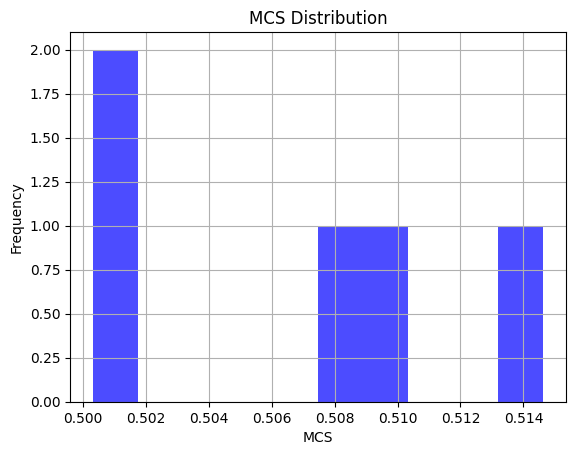

In [2]:
from typing import List, Tuple, Dict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import matplotlib.pyplot as plt

# Proxy Model Class
class ProxyModel:
    def __init__(self, model_name: str):
        self.model_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name)
        self.explainer = pipeline("text-classification", model=self.model, tokenizer=self.tokenizer)

    def explain(self, text: str) -> Dict[str, float]:
        """
        Generate attribution-like scores for each label.
        """
        predictions = self.explainer(text, return_all_scores=True)[0]
        return {item['label']: item['score'] for item in predictions}


# Misclassification Confidence Score Calculator
class MisclassificationScore:
    @staticmethod
    def calculate(predicted: Dict[str, float], true_label: str) -> float:
        """
        Calculate MCS: the difference between max incorrect and true label scores.
        """
        true_score = predicted.get(true_label, 0)
        max_false_score = max([score for label, score in predicted.items() if label != true_label], default=0)
        return max_false_score - true_score


# Few-Shot Prompt Class
class FewShotPrompt:
    def __init__(self, proxy_model: ProxyModel, top_k_keywords: int):
        self.proxy_model = proxy_model
        self.top_k_keywords = top_k_keywords

    def generate_rationale(self, text: str, label: str) -> str:
        """
        Generate a rationale using top-k keywords based on attribution scores.
        """
        predictions = self.proxy_model.explain(text)
        sorted_keywords = sorted(predictions.items(), key=lambda x: x[1], reverse=True)[:self.top_k_keywords]
        keywords = [word for word, _ in sorted_keywords]
        return f"The key words: {', '.join(keywords)} are crucial clues for predicting {label} as the correct answer."

    def construct_prompt(self, samples: List[Tuple[str, str]]) -> str:
        """
        Construct the full few-shot prompt.
        """
        prompt = ""
        for text, label in samples:
            rationale = self.generate_rationale(text, label)
            prompt += f"Input: {text}\nRationale: {rationale}\nLabel: {label}\n\n"
        return prompt


# Amplify Framework Class
class AmplifyFramework:
    def __init__(self, proxy_model_name: str, top_k_samples: int, top_k_keywords: int):
        self.proxy_model = ProxyModel(proxy_model_name)
        self.top_k_samples = top_k_samples
        self.top_k_keywords = top_k_keywords

    def select_samples(self, validation_set: List[Tuple[str, str]]) -> List[Tuple[str, str]]:
        """
        Select top-k samples with the highest MCS.
        """
        scored_samples = []
        for text, label in validation_set:
            predictions = self.proxy_model.explain(text)
            mcs = MisclassificationScore.calculate(predictions, label)
            scored_samples.append((text, label, mcs))
        
        scored_samples.sort(key=lambda x: x[2], reverse=True)
        return [(sample[0], sample[1]) for sample in scored_samples[:self.top_k_samples]]

    def run(self, validation_set: List[Tuple[str, str]]) -> str:
        """
        Execute the AMPLIFY pipeline and construct a prompt.
        """
        selected_samples = self.select_samples(validation_set)
        prompt_generator = FewShotPrompt(self.proxy_model, self.top_k_keywords)
        return prompt_generator.construct_prompt(selected_samples)


# Visualization Class
class ExperimentVisualizer:
    @staticmethod
    def plot_mcs_distribution(mcs_scores: List[float], title: str = "MCS Distribution"):
        """
        Visualize the MCS distribution of selected samples.
        """
        plt.hist(mcs_scores, bins=10, color='blue', alpha=0.7)
        plt.title(title)
        plt.xlabel("MCS")
        plt.ylabel("Frequency")
        plt.grid(True)
        plt.show()


# Main Example
if __name__ == "__main__":
    # Example validation data
    validation_data = [
        ("The movie was fantastic and had great visuals.", "Positive"),
        ("The food was terrible and the service was slow.", "Negative"),
        ("The book was engaging but the ending was disappointing.", "Neutral"),
        ("The product quality was outstanding and delivery was quick.", "Positive"),
        ("The app crashed frequently and was full of bugs.", "Negative"),
    ]

    # Initialize AMPLIFY framework
    amplify = AmplifyFramework(proxy_model_name="distilbert-base-uncased", top_k_samples=3, top_k_keywords=3)

    # Run framework
    few_shot_prompt = amplify.run(validation_data)

    # Display the prompt
    print("Constructed Few-Shot Prompt:\n")
    print(few_shot_prompt)

    # Visualize MCS distribution
    proxy_model = amplify.proxy_model
    mcs_scores = [
        MisclassificationScore.calculate(proxy_model.explain(text), label)
        for text, label in validation_data
    ]
    ExperimentVisualizer.plot_mcs_distribution(mcs_scores)
